# Task 4 - Educational Platform and the Front Door Criterion

## Example
### Scenario
The goal is to use the front door criterion to measure the causal effect of motivational messages on student engagement. 

### Steps:
1. Use DAG to visualize Data relationships
2. Create Data
3. First stage (Model the effect of X on M):
* This model estimates the impact of the treatment (sending messages) on the students study habits 
* P(M=m ∣ X=x) = β0,M +β1,M * x
4. Second stage (Model the effect of M on Y, controlling for X):
* This model estimates the effect of study habits on student engagement, while controlling for the direct effect of the motivational messages. 
* P(Y=y | X=x’, M=m) = β0,Y + β1,Y * x’ + β2,Y * m
5. Calculate Marginal Probability
*  P(X=x’) = empirical distribution
6. Compute the expected values
* E[Y ∣ do(X=x)] = ∑m P(M=m ∣ X=x) ∑x’ P(Y ∣ X=x’, M=m) P(X=x’)
7. Estimate the causal effect
* Causal Effect = E[Y | do(X=1)] – E[Y | do (X=0)]

### Variables: 
* X (Treatment): Motivational message (0 = not sent , 1 = sent)
* Y (Outcome): Student engagement measured on a continous scale from 0 to 1
* M (Mediator): Study habits measured on a scale from 0 to 1.
* U (Unmeasured Confounder): This could be the socioeconomic status, or the students mood for this example it will be introduced on a continous scale from 0 to 1. Only for data generation purposes.

### Front Door Criterion:
1.	 M (Mediator) intercepts all direct paths from X (intervention or treatment) to Y (out-come):
The primary causal pathway should be X→M→Y, with no direct edge from X to Y.
In the example case the only direct path from X to Y through M. 
Condition is met.
2.	 No unblocked backdoor path from X to M:
There should not be any confounders that open a backdoor path from X to M. 
In the example case there is no backdoor path from X to M.
Condition is met.
3.	 All backdoor paths from M to Y are blocked by X:
Potential confounders affecting both M and Y should be blocked by X.
In the example the unmeasured confounder U does not directly affect M. 
Condition is met.


### Basic Formulas
1. Front Door Adjustment Formula:
* P[Y ∣ do(X=x)] = ∑m P(M=m ∣ X=x) ∑x’ P(Y ∣ X=x’, M=m) P(X=x’)
2. Expected Value Calculation
* E[Y ∣ do(X=x)] = ∑m P(M=m ∣ X=x) ∑x’ P(Y ∣ X=x’, M=m) P(X=x’)

In [231]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from scipy.special import expit as sigmoid

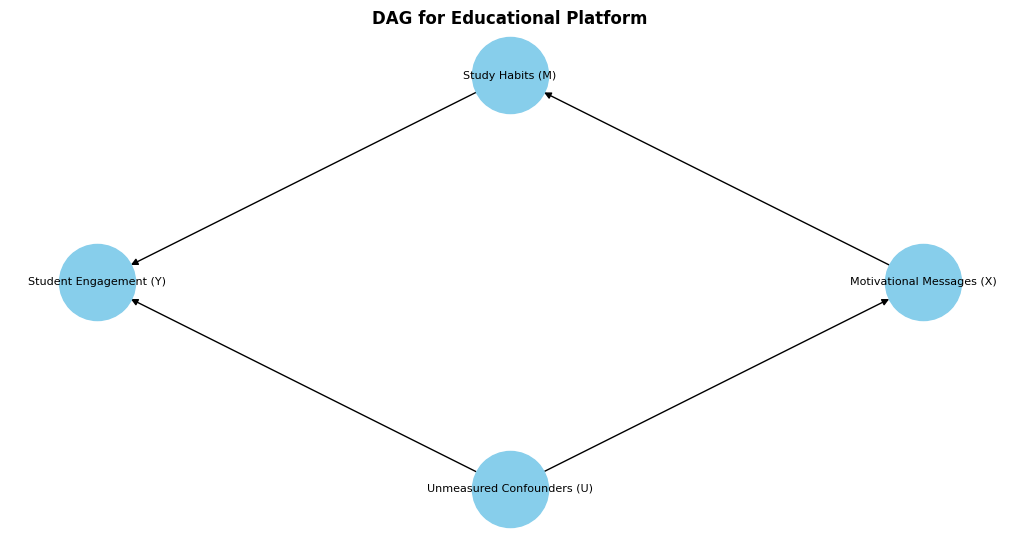

In [236]:
# Create a directed graph
dag = nx.DiGraph()

# Add nodes with labels
nodes = {
    'X': 'Motivational Messages (X)',
    'M': 'Study Habits (M)',
    'Y': 'Student Engagement (Y)',
    'U': 'Unmeasured Confounders (U)',
}

# Add edges with labels
edges = [
    ('X', 'M'),
    ('M', 'Y'),
    ('U', 'Y'),
    ('U', 'X')
]

dag.add_edges_from(edges)

plt.figure(figsize=(10, 5))

pos = nx.circular_layout(dag)
nx.draw(dag, pos, with_labels=False, node_size=3000, node_color='skyblue', font_size=9, font_weight='bold')

for p in pos:  # raise text positions
    pos[p][1] += 0.0
nx.draw_networkx_labels(dag, pos, labels=nodes, font_size=8)


plt.title('DAG for Educational Platform', fontweight='bold')
plt.show() 

In [233]:
# Data Generation
np.random.seed(73)
data_size = 1000

def sigmoid(x):
    return 1/(1+np.exp(-x))

# Confounder U
U = np.random.normal(0, 1, data_size) #random continous variable, this is would not be measured in real world data but we need it to simulate the effect of unmeasured confounders

# Treatment/Intervention X
X = np.random.binomial(1, 0.5 + 0.2 * U / 10, data_size)  #Probability influenced by U

# Mediator M
M = sigmoid(0.5 + 0.3 * X + np.random.normal(0, 0.1, data_size)) #Influenced by X, we assume that habits can be measured on a continuous scale

# Outcome Y
Y = sigmoid(0.5 + 0.3 * M + 0.1 * U + np.random.normal(0, 0.1, data_size)) #Influenced by M and U

df = pd.DataFrame({'U': U, 'X': X, 'M': M, 'Y': Y})

df.head()

,U,X,M,Y
0,0.576813,0,0.613234,0.678438
1,2.131109,1,0.711984,0.726367
2,2.440220,0,0.607327,0.710669
3,0.263327,1,0.689855,0.698325
4,-1.496121,1,0.665414,0.580657


In [234]:

# Step 1: Estimate P(M|X) using linear regression
model_m_x = LinearRegression()
model_m_x.fit(df[['X']], df['M'])

# Predict P(M|X)
df['P_M_given_X'] = model_m_x.predict(df[['X']])

# Step 2: Estimate P(Y|X, M) using linear regression
model_y_xm = LinearRegression()
model_y_xm.fit(df[['X', 'M']], df['Y'])

# Predict P(Y|X, M)
df['P_Y_given_XM'] = model_y_xm.predict(df[['X', 'M']])

# Step 3: Calculate the marginal probability of X
p_x_prime = df['X'].value_counts(normalize=True).sort_index()

# Step 4: Calculate E[Y|do(X=1)] and E[Y|do(X=0)] using the full formula
def calculate_do_y(df, x_value):
    do_y = 0
    unique_m_values = np.linspace(df['M'].min(), df['M'].max(), 100)  # Discretize M
    for m_value in unique_m_values:
        p_m_given_x = model_m_x.predict(pd.DataFrame({'X': [x_value]}))[0]
        inner_sum = 0
        for x_prime in p_x_prime.index:
            p_y_given_xm = model_y_xm.predict(pd.DataFrame({'X': [x_prime], 'M': [m_value]}))[0]
            inner_sum += p_y_given_xm * p_x_prime[x_prime]
        do_y += inner_sum * p_m_given_x
    return do_y / len(unique_m_values)

do_y_given_x1 = calculate_do_y(df, 1)
do_y_given_x0 = calculate_do_y(df, 0)

# Estimate the causal effect of X on Y
causal_effect = do_y_given_x1 - do_y_given_x0
print(f'Estimated Causal Effect of X on Y: {causal_effect}')

Estimated Causal Effect of X on Y: 0.04501340468169773


### Interpretation of Results
The data used here leads to an estimated causal effect of 4.5%, which can be good or bad depending on the goal of the intervention. 